# Homework 1. Likelihood-based models

- Seminar (5 points): Warmup
- **Task 1 (10 points): PixelCNN**
- Task 2 (10 points): Conditional PixelCNN
- Task 3 (10 points): RealNVP
- \* Bonus (10+++ points)

## Task 1. PixelCNN on Shapes and MNIST

In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images

Recap:

$$Mask_a
=
\begin{bmatrix}
1 & 1 & 1 \\
1 & 0 & 0 \\
0 & 0 & 0 \\
\end{bmatrix}$$

$$Mask_b
=
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 0 \\
0 & 0 & 0 \\
\end{bmatrix}$$

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import math
from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm

%matplotlib inline

In [2]:
torch.manual_seed(42)

In [3]:
import pickle
from torchvision.utils import make_grid


def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        savefig(fname)
    else:
        plt.show()
        

def load_data(fname, binarize=True, include_labels=False):
    with open(fname, 'rb') as data_file:
        data = pickle.load(data_file)
    
    if include_labels:
        return (data['train'] > 127.5), (data['test'] > 127.5), data['train_labels'], data['test_labels']
    
    return (data['train'] > 127.5), (data['test'] > 127.5)


class SimpleDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
        
        assert len(X) == len(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

First of all, we need to modify `Conv2d` with masking

In [4]:
class MaskedConv2D(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)
    
    def forward(self, x):
        """
        x: (N, C_in, H_in, W_in) torch.Tensor
        Returns
          - out (N, C_out, H_out, W_out) should be conv2d(x, weight * mask) + bias 
        """
        return self._conv_forward(x, self.weight * self.mask, self.bias)
    
    def create_mask(self, mask_type):
        assert mask_type == 'A' or mask_type == 'B'
        k = self.kernel_size[0]
        for i in range(k // 2):
            self.mask[:, :, i] = torch.ones(1, k)
        for i in range(k // 2):
            self.mask[:, :, k // 2, i] = 1
        self.mask[:, :, k // 2, k // 2] = 1 if mask_type == 'B' else 0
        

In [5]:
convA = MaskedConv2D('A', 1, 1, kernel_size=3)
convB = MaskedConv2D('B', 1, 1, kernel_size=3)
#print(convA.mask.view(-1), [1., 1., 1., 1., 0., 0., 0., 0., 0.])
#print(convB.mask.view(-1), [1., 1., 1., 1., 1., 0., 0., 0., 0.])
assert np.allclose(convA.mask.view(-1), [1., 1., 1., 1., 0., 0., 0., 0., 0.], atol=1e-6)
assert np.allclose(convB.mask.view(-1), [1., 1., 1., 1., 1., 0., 0., 0., 0.], atol=1e-6)

In [6]:
class PixelCNN(nn.Module):
    def __init__(self, input_shape, n_colors=2, n_filters=64,
               kernel_size=7, n_layers=5):
        super().__init__()
        assert n_layers >= 2
        n_channels = input_shape[0]
        
        self.input_shape = input_shape
        self.n_channels = n_channels
        self.n_colors = n_colors
        
        modules = []
        modules += [
            MaskedConv2D('A', in_channels=n_channels, out_channels=n_filters, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.ReLU(),

        ]

        for _ in range(n_layers):
            modules += [
                MaskedConv2D('B', in_channels=n_filters, out_channels=n_filters, kernel_size=kernel_size, padding=kernel_size // 2),
                #nn.BatchNorm2d(n_filters),
                nn.ReLU()
            ]
        

        modules += [
            MaskedConv2D('B', in_channels=n_filters, out_channels=n_filters, kernel_size=1, padding=0),
            #nn.BatchNorm2d(n_filters),
            nn.ReLU(),
            MaskedConv2D('B', in_channels=n_filters, out_channels=1, kernel_size=1, padding=0),
        ]

        self.net = nn.ModuleList(modules)
        self.linear = nn.Linear(1, n_colors)
        
    def forward(self, x, cond=None):
        batch_size = x.shape[0]
        x = (x.float() / (self.n_colors - 1) - 0.5) / 0.5

        for layer in self.net:
            x = layer(x)
        
        x = self.linear(x[..., None])
        return x.permute(0, 4, 1, 2, 3)

    def loss(self, x):
        target = x.long()
        pred = self.forward(x)
        
        return F.cross_entropy(pred, target)

    def sample(self, n):
        samples = torch.zeros(n, *self.input_shape).cuda()
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    for k in range(self.n_channels):
                        logits = self.forward(samples)[:, :, k, r, c]
                        probs = F.softmax(logits, dim=1)
                        samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

Feel free to use and modify this train loop. You may want to show some logs or sampling results during training

In [7]:
from typing import Tuple, Any
from torchvision.transforms import ToTensor, Compose, Scale

class ShapesDataset(Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        sample = torch.FloatTensor(self.data[index]).permute(2, 0, 1)

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample, torch.Tensor([0])
    
    
class MinMaxScalerVectorized(object):
    """MinMax Scaler

    Transforms each channel to the range [a, b].

    Parameters
    ----------
    feature_range : tuple
        Desired range of transformed data.
    """

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __call__(self, tensor):
        """Fit features

        Parameters
        ----------
        stacked_features : tuple, list
            List of stacked features.

        Returns
        -------
        tensor 
            A tensor with scaled features using requested preprocessor.
        """

        #tensor = torch.stack(tensor)

        # Feature range
        a, b = self.feature_range

        #print(tensor.max(dim=0, keepdim=True)[0])
        dist = tensor.max(dim=1, keepdim=True)[0] - tensor.min(dim=1, keepdim=True)[0]
        dist[dist == 0.0] = 1.0
        scale = 1.0 / dist
        tensor.mul_(scale).sub_(tensor.min(dim=1, keepdim=True)[0])
        tensor.mul_(b - a).add_(a)

        return tensor


In [8]:
def train(model, train_loader, optimizer):
    model.train()
    train_losses = []
    for x, _ in train_loader:
        x = x.cuda()
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses


def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.cuda()
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in range(epochs):
        print(f'epoch {epoch} started')
        model.train()
        train_losses.extend(train(model, train_loader, optimizer))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        print('train loss: {}, test_loss: {}'.format(np.mean(train_losses[-1000:]), 
                                                     test_losses[-1]))

    return train_losses, test_losses


def train_model(train_data, test_data, model, train_dataloader_kwargs, test_dataloader_kwargs, training_kwargs):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    model: nn.Model item, should contain function loss and accept
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - trained model
    """
    model.cuda()
    test_losses = []
    train_losses = []

    train_transforms = Compose([
        MinMaxScalerVectorized(feature_range=(-1, 1)),
    ])

    test_transforms = Compose([
        MinMaxScalerVectorized(feature_range=(-1, 1)),
    ])

    train_dataset = ShapesDataset(train_data, transforms=None)
    test_dataset = ShapesDataset(test_data, transforms=None)

    train_dataloader = DataLoader(train_dataset, **train_dataloader_kwargs)
    test_dataloader = DataLoader(test_dataset, **test_dataloader_kwargs)

    test_losses.append(eval_loss(model, test_dataloader))

    train_loss, test_loss = train_epochs(model, train_dataloader, test_dataloader, training_kwargs)
    test_losses += test_loss
    train_losses += train_loss

    return np.array(train_losses), np.array(test_losses), model
    

### First dataset: **Shapes** (5 points)

In [9]:
# For colab users: download file
#! wget https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/shapes.pkl

In [10]:
shapes_train, shapes_test = load_data('./shapes.pkl')

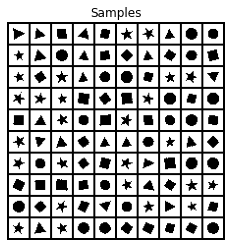

In [11]:
show_samples(shapes_train[:100])

In [12]:
torch.manual_seed(42)

In [13]:
train_dataloader_config = {
    'batch_size': 128,
    'shuffle': True,
}

test_dataloader_config = {
    'batch_size': 128,
    'shuffle': False,
}

learning_config = {
    'lr': 1E-3,
    'epochs': 10,
}

In [14]:
H, W, _ = shapes_train[0].shape
model = PixelCNN((1, H, W))
train_losses, test_losses, shapes_model = train_model(shapes_train, shapes_test, model, train_dataloader_config, test_dataloader_config, learning_config)

epoch 0 started
train loss: 0.401602871534301, test_loss: 0.1579667031764984
epoch 1 started
train loss: 0.27159266569083784, test_loss: 0.12090399861335754
epoch 2 started
train loss: 0.21974250289603947, test_loss: 0.10667724162340164
epoch 3 started
train loss: 0.1883359733832682, test_loss: 0.09130113571882248
epoch 4 started
train loss: 0.1666890288271555, test_loss: 0.07450101524591446
epoch 5 started
train loss: 0.1508910225598308, test_loss: 0.06806680560112
epoch 6 started
train loss: 0.13867509132088893, test_loss: 0.060279108583927155
epoch 7 started
train loss: 0.12873636809654715, test_loss: 0.05762772634625435
epoch 8 started
train loss: 0.12068340731002289, test_loss: 0.05259256809949875
epoch 9 started
train loss: 0.11382496272917927, test_loss: 0.05045374482870102


In [15]:
def show_train_plots(train_losses, test_losses, title):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    plt.show()

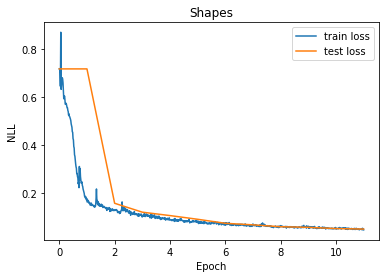

In [16]:
show_train_plots(train_losses, test_losses, 'Shapes')

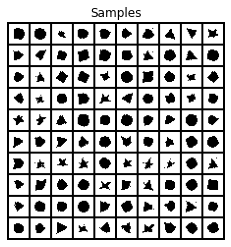

In [17]:
samples = shapes_model.sample(100)
show_samples(samples)

### Second dataset: MNIST (5 points)

In [18]:
# For colab users: download file
#! wget https://github.com/egiby/Generative-Models-MIPT/raw/hw1/module1-likelihood/mnist.pkl

In [19]:
mnist_train, mnist_test = load_data('./mnist.pkl')

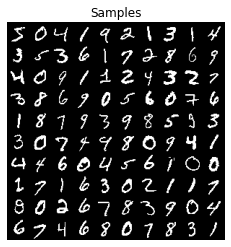

In [20]:
show_samples(mnist_train[:100])

In [21]:
train_dataloader_config = {
    'batch_size': 128,
    'shuffle': True,
}

test_dataloader_config = {
    'batch_size': 128,
    'shuffle': False,
}

learning_config = {
    'lr': 1E-3,
    'epochs': 10,
}

In [22]:
H, W, _ = mnist_train[0].shape
model = PixelCNN((1, H, W))
train_losses, test_losses, mnist_model = train_model(mnist_train, mnist_test, model, train_dataloader_config, test_dataloader_config, learning_config)

epoch 0 started
train loss: 0.12369040523701386, test_loss: 0.08616936206817627
epoch 1 started
train loss: 0.1042743385759498, test_loss: 0.08309537172317505
epoch 2 started
train loss: 0.08377232836186886, test_loss: 0.08163534104824066
epoch 3 started
train loss: 0.08153874617815017, test_loss: 0.07979807257652283
epoch 4 started
train loss: 0.08025322863459587, test_loss: 0.0790909007191658
epoch 5 started
train loss: 0.07940133507549763, test_loss: 0.07818784564733505
epoch 6 started
train loss: 0.07873810746520758, test_loss: 0.07797656953334808
epoch 7 started
train loss: 0.07819896598905325, test_loss: 0.07766486704349518
epoch 8 started
train loss: 0.07767787911742925, test_loss: 0.07700126618146896
epoch 9 started
train loss: 0.07726615247875453, test_loss: 0.07712768763303757


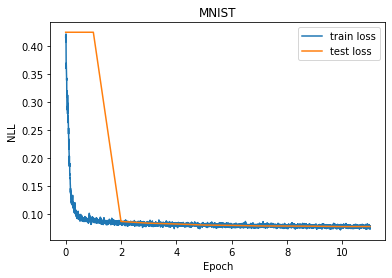

In [23]:
show_train_plots(train_losses, test_losses, 'MNIST')

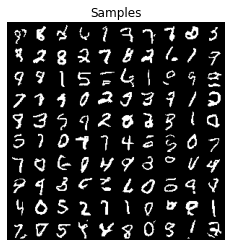

In [24]:
samples = mnist_model.sample(100)
show_samples(samples)